In [1]:
import torch
import torch.nn as nn

In [11]:
import os
from PIL import Image
import pickle
import numpy as np
import matplotlib.pyplot as plt


In [4]:
from odise.modeling.meta_arch.ldm import LdmFeatureExtractor
import torchvision.transforms as T
from termcolor import cprint

device = torch.device('cuda:0')

feature_extractor = LdmFeatureExtractor(
            encoder_block_indices=(5, 7),
            unet_block_indices=(2, 5, 8, 11),
            decoder_block_indices=(2, 5),
            steps=(0,),
            captioner=None,
        ).to(device)
diffusion_preprocess = T.Resize(512, antialias=True)
cprint("diffusion feature dims: "+str(feature_extractor.feature_dims), "yellow")


LatentDiffusion: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, con

/home/bruce/anaconda3/envs/manigaussian/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
The checkpoint state_dict contains keys that are not used by the model:
  model_ema.{decay, num_updates}


diffusion feature dims: [512, 512, 2560, 1920, 960, 640, 512, 512]


In [302]:
tasks = [
    # "close_jar",
        #  "open_drawer",
        #  "sweep_to_dustpan_of_size" ,
        #  "meat_off_grill" ,
         "turn_tap" ,
        #  "slide_block_to_color_target",
        #  "put_item_in_drawer",
        #  "reach_and_drag",
        #  "push_buttons",
        #  "stack_blocks"
         ]

var = 0
for task in tasks:
    episode = 0
    data_dir  = f'../data/test_data/{task}/all_variations/episodes/episode{episode}/'
    # low_dim_obs
    # variation_descriptions
    # variation_number
    with open(data_dir+'low_dim_obs.pkl', 'rb') as f:
        obs = pickle.load(f)
    with open(data_dir+'variation_descriptions.pkl', 'rb') as f:
        descriptions = pickle.load(f)
    # var+=obs
    print(task, descriptions)
var

turn_tap ['turn right tap', 'rotate the right tap', 'grasp the right tap and turn it']


0

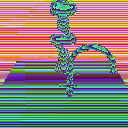

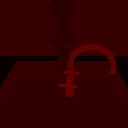

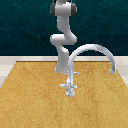

In [303]:

front_depth = Image.open(data_dir+'front_depth/0.png')
front_mask = Image.open(data_dir+'front_mask/0.png')
front_rgb = Image.open(data_dir+'front_rgb/0.png')
display(front_depth)
display(front_mask)
display(front_rgb)
# obs = os.listdir(data_dir)

In [304]:
front_mask = np.array(front_mask)
# front_mask[front_mask<45]=0
# front_mask[front_mask>=100]=0
# plt.imshow(front_mask)
set(front_mask[front_mask !=0])

{10, 31, 34, 42, 43, 44, 45, 46, 48, 52, 55, 95, 98, 105}

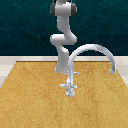

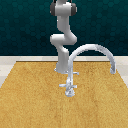

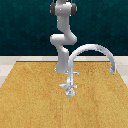

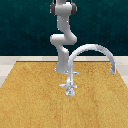

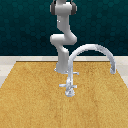

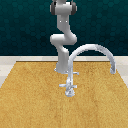

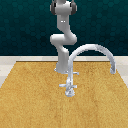

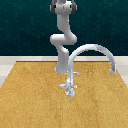

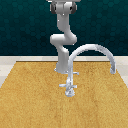

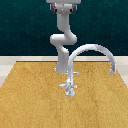

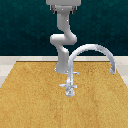

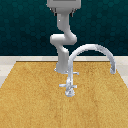

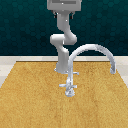

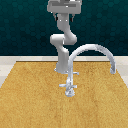

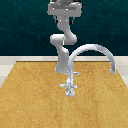

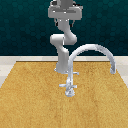

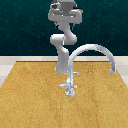

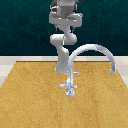

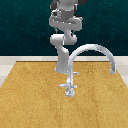

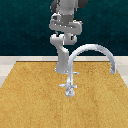

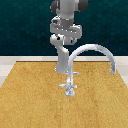

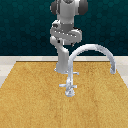

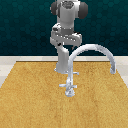

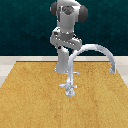

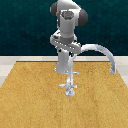

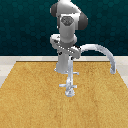

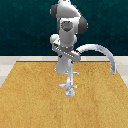

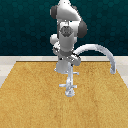

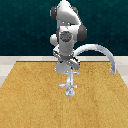

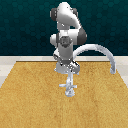

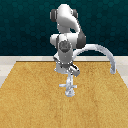

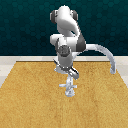

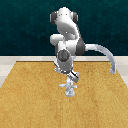

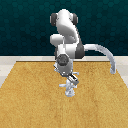

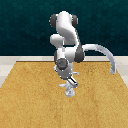

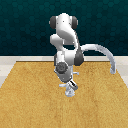

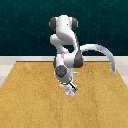

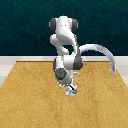

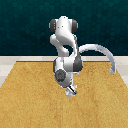

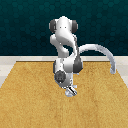

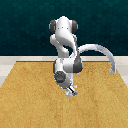

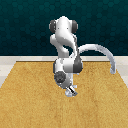

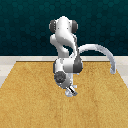

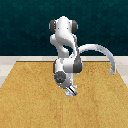

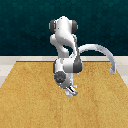

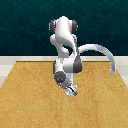

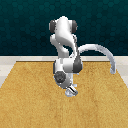

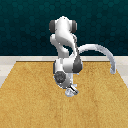

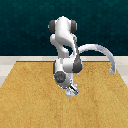

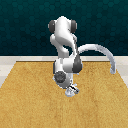

In [305]:
for i in range(50):
    front_rgb = Image.open(data_dir+f'front_rgb/{i}.png')
    display(front_rgb)

In [306]:
# lang_goal = descriptions
lang_goal = np.array([descriptions[0]], dtype=object)
# lang_goal
if lang_goal.shape[0] > 1:
    caption = ['a robot arm ' + cap.item() for cap in lang_goal]
else:
    caption = "a robot arm " + lang_goal.item()
caption

'a robot arm turn right tap'

In [307]:
"""
we support multiple captions for batched input here
"""
caption = 'a robot arm'
gt_rgb = torch.tensor(np.array(front_rgb))
gt_rgb = gt_rgb[None,...].to(device)
gt_rgb = (gt_rgb/255)*2 - 1
# flatten_gt_rgb = [rp[0] for rp in gt_rgb][0]
print(gt_rgb.shape,caption)


batched_input = {'img': diffusion_preprocess(gt_rgb.permute(0, 3, 1, 2)), 
                 'caption': caption}
print(batched_input['img'].device)
feature_list, lang_embed = feature_extractor(batched_input) # list of visual features, and 77x768 language embedding
# used_feature_idx = -1  
# gt_embed = feature_list[used_feature_idx]   # [bs,512,128,128]




torch.Size([1, 128, 128, 3]) a robot arm
cuda:0


In [308]:
# feature_list[-1].shape # torch.Size([1, 512, 128, 128])
gt_embed = feature_list[-1]   # [bs,512,128,128]

In [309]:
# NOTE: dimensionality reduction with PCA, which is used to satisfy the output dimension of the Gaussian Renderer
bs = gt_rgb.shape[0]
A = gt_embed.reshape(bs, 512, -1).permute(0, 2, 1)  # [bs, 128*128, 512]
# print(A.shape) ([1, 16384, 512])
gt_embed_list = []
for i in range(bs):
    U, S, V = torch.pca_lowrank(A[i], q=np.maximum(6, 3))
    print(U.shape, S.shape, V.shape)
    reconstructed_embed = torch.matmul(A[i], V[:, :3])
    gt_embed_list.append(reconstructed_embed)
    print(reconstructed_embed.shape)

gt_embed = torch.stack(gt_embed_list, dim=0).permute(0, 2, 1).reshape(bs, 3, 128, 128)

torch.Size([16384, 6]) torch.Size([6]) torch.Size([512, 6])
torch.Size([16384, 3])


In [310]:
gt_rgb[0]

tensor([[[-1.0000, -0.5686, -0.5294],
         [-1.0000, -0.6314, -0.5922],
         [-1.0000, -0.5765, -0.5373],
         ...,
         [-1.0000, -0.5765, -0.5451],
         [-1.0000, -0.5765, -0.5451],
         [-1.0000, -0.5765, -0.5451]],

        [[-1.0000, -0.5686, -0.5294],
         [-1.0000, -0.6078, -0.5686],
         [-1.0000, -0.6392, -0.5922],
         ...,
         [-1.0000, -0.5765, -0.5451],
         [-1.0000, -0.5765, -0.5451],
         [-1.0000, -0.5765, -0.5451]],

        [[-1.0000, -0.5765, -0.5373],
         [-1.0000, -0.6392, -0.6000],
         [-1.0000, -0.5843, -0.5529],
         ...,
         [-1.0000, -0.5843, -0.5529],
         [-1.0000, -0.5843, -0.5529],
         [-1.0000, -0.5843, -0.5529]],

        ...,

        [[ 0.6157,  0.2941, -0.3255],
         [ 0.5765,  0.2000, -0.4196],
         [ 0.6314,  0.3333, -0.2941],
         ...,
         [ 0.5922,  0.3176, -0.2784],
         [ 0.5294,  0.2549, -0.3176],
         [ 0.6392,  0.4118, -0.1922]],

        [[

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


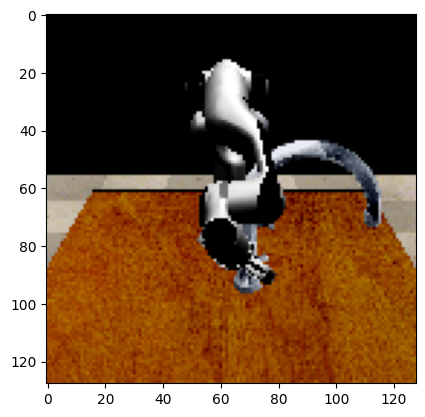

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-63.755417..226.17847].


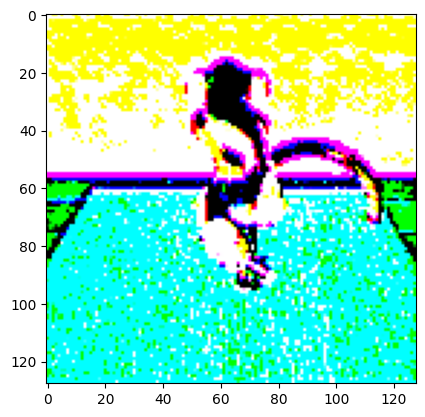

In [311]:
gt_embed = gt_embed.cpu()

plt.imshow(gt_rgb[0].cpu())
plt.show()
plt.imshow(gt_embed[0].permute(1,2,0))
plt.show()

In [312]:
def visualize_feature_map_by_normalization(features):
    '''
    Normalize feature map to [0, 1] for plt.show()
    :features: (B, 3, H, W)
    Return: (H, W, 3)
    '''
    # print(features.shape)
    MIN_DENOMINATOR = 1e-12
    features = features[0].cpu().detach().numpy()
    features = features.transpose(1, 2, 0)  # [H, W, 3]
    features = features / (np.linalg.norm(features, axis=-1, keepdims=True) + MIN_DENOMINATOR)
    return features

In [313]:
print(gt_embed.shape)
gt_render = visualize_feature_map_by_normalization(gt_embed)
print(gt_render.shape)

torch.Size([1, 3, 128, 128])
(128, 128, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99912244..0.99997306].


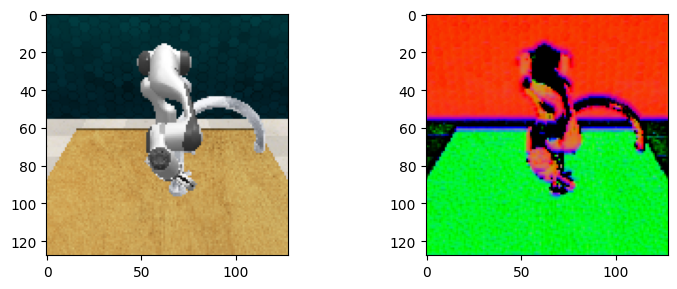

In [314]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].imshow((gt_rgb[0].cpu()+1)/2)
# gt_render[...,2]=0
axs[1].imshow(gt_render)
plt.tight_layout()
# plt.imshow(gt_render)

plt.savefig('gt_render.png')

In [315]:
def extract_foundation_model_feature(gt_rgb, caption):
    """
    we use the last layer of the diffusion feature extractor
    since we reshape 128x128 img to 512x512, the last layer's feature is just 128x128
    thus, no need to resize the feature map
    lang_goal: numpy.ndarray, [bs, 1, 1]
    """
    # print(f'gt_rgb: {gt_rgb}')
    # print(f'lang_goal: {lang_goal}')

    """
    we support multiple captions for batched input here
    """
    # if lang_goal.shape[0] > 1:
    #     caption = ['a robot arm ' + cap.item() for cap in lang_goal]
    # else:
    #     caption = "a robot arm " + lang_goal.item()
    batched_input = {'img': diffusion_preprocess(gt_rgb.permute(0, 3, 1, 2)), 'caption': caption}
    feature_list, lang_embed = feature_extractor(batched_input) # list of visual features, and 77x768 language embedding
    # print(feature_list)
    used_feature_idx = -1  
    gt_embed = feature_list[used_feature_idx]   # [bs,512,128,128]

    # NOTE: dimensionality reduction with PCA, which is used to satisfy the output dimension of the Gaussian Renderer
    bs = gt_rgb.shape[0]
    A = gt_embed.reshape(bs, 512, -1).permute(0, 2, 1)  # [bs, 128*128, 512]
    gt_embed_list = []
    for i in range(bs):
        U, S, V = torch.pca_lowrank(A[i], q=np.maximum(6, 3))
        reconstructed_embed = torch.matmul(A[i], V[:, :3])
        gt_embed_list.append(reconstructed_embed)

    gt_embed = torch.stack(gt_embed_list, dim=0).permute(0, 2, 1).reshape(bs, 3, 128, 128)
    return gt_embed

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9994806..0.9994322].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9985954..0.99895626].


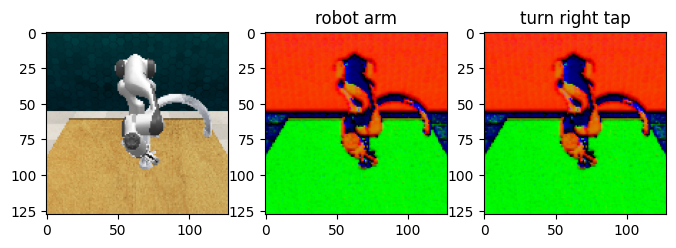

In [325]:
"""
we support multiple captions for batched input here
"""
caption_1 = 'robot arm'
gt_rgb_1 = torch.tensor(np.array(front_rgb))
gt_rgb_1 = gt_rgb_1[None,...].to(device)
gt_rgb_1 = (gt_rgb_1/255)*2 - 1

caption_2 = 'turn right tap'
gt_rgb_2 = torch.tensor(np.array(front_rgb))
gt_rgb_2 = gt_rgb_2[None,...].to(device)
gt_rgb_2 = (gt_rgb_2/255)*2 - 1

gt_embed_1 = extract_foundation_model_feature(gt_rgb_1, caption_1)
gt_embed_2 = extract_foundation_model_feature(gt_rgb_2, caption_2)


fig, axs = plt.subplots(1, 3, figsize=(8, 3))
axs[1].title.set_text('gt_rgb')
axs[0].imshow((gt_rgb[0].cpu()+1)/2)
# gt_render[...,2]=0
axs[1].title.set_text(caption_1)
axs[1].imshow(visualize_feature_map_by_normalization(gt_embed_1))
axs[2].title.set_text(caption_2)
axs[2].imshow(visualize_feature_map_by_normalization(gt_embed_2))
# plt.tight_layout()
# plt.imshow(gt_render)

plt.savefig('gt_render.png')

In [326]:
gt_embed_1.shape

torch.Size([1, 3, 128, 128])

In [327]:
torch.sum(torch.sum(gt_embed_1-gt_embed_2,dim=1))

tensor(-7882.7642, device='cuda:0')

# SAM

In [90]:
import torch
from PIL import Image
import requests
from transformers import SamModel, SamProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
mask_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
segmentation_map = Image.open(requests.get(mask_url, stream=True).raw).convert("1")
input_points = [[[450, 600]]]  # 2D location of a window in the image

inputs = processor(raw_image, 
                   input_points = input_points, 
                   segmentation_map = segmentation_map,
                   return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores

Unused or unrecognized kwargs: segmentation_map.


In [91]:
img = torch.zeros(*masks[0].shape)
img[masks[0]==True] = 1

rimg = torch.tensor(np.array(raw_image))/255

In [92]:
# plt.imshow(rimg/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.003921569..1.9843137].


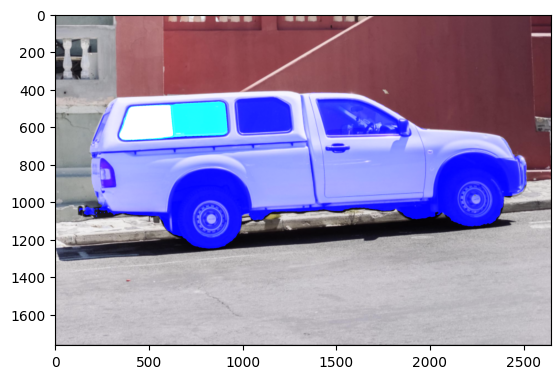

In [93]:
plt.imshow(rimg+img[0].permute(1,2,0))